In [1]:
import os, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, f1_score  
import matplotlib.pyplot as plt

In [2]:
device = (torch.device("mps") if torch.backends.mps.is_available()
          else torch.device("cuda") if torch.cuda.is_available()
          else torch.device("cpu"))
print("Using", device)

Using mps


In [3]:
X_src_train = np.load('data_src/X_src_train.npy')
y_src_train = np.load('data_src/y_src_train.npy')
X_src_val = np.load('data_src/X_src_test.npy')      
y_src_val = np.load('data_src/y_src_test.npy')     
X_t_train = np.load('data_tgt/X_tgt_train.npy')
y_t_train = np.load('data_tgt/y_tgt_train.npy')
X_t_test = np.load('data_tgt/X_tgt_test.npy')
y_t_test = np.load('data_tgt/y_tgt_test.npy')

In [4]:
from sklearn.model_selection import train_test_split
INPUT_DIM = X_src_train.shape[1]
BATCH_SIZE = 64
EPOCHS = 40

def make_loader(X, y=None, batch_size=64, shuffle=True):
    if y is not None:
        ds = TensorDataset(torch.from_numpy(np.array(X)).float(),
                           torch.from_numpy(np.array(y)).float().unsqueeze(1))
    else:
        ds = TensorDataset(torch.from_numpy(np.array(X)).float())
    return DataLoader(ds, batch_size=batch_size, drop_last=True)

src_loader = make_loader(X_src_train, y_src_train, BATCH_SIZE)
tgt_loader = make_loader(X_t_train, None, BATCH_SIZE)
val_loader = make_loader(X_src_val, y_src_val, BATCH_SIZE)  

In [5]:
class GradientReversalFunction(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)
    
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

class GradientReversalLayer(nn.Module):
    def __init__(self, alpha=1.0):
        super().__init__()
        self.alpha = alpha
    
    def forward(self, x):
        return GradientReversalFunction.apply(x, self.alpha)
    
    def set_alpha(self, alpha):
        self.alpha = alpha


In [6]:
class Encoder(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512), nn.ReLU(), nn.BatchNorm1d(512), nn.Dropout(0.3),
            nn.Linear(512, 256), nn.ReLU(), nn.BatchNorm1d(256), nn.Dropout(0.3),
            nn.Linear(256, 128), nn.ReLU(), nn.BatchNorm1d(128), nn.Dropout(0.3)
        )
    def forward(self, x): 
        return self.net(x)

class TaskClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(64, 16), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(16, 1)  
        )
    def forward(self, x): 
        return self.net(x)

class DomainDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(64, 1) 
        )
    def forward(self, features):
        return self.net(features)

In [7]:
class DANN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.feature_extractor = Encoder(input_dim)
        self.label_predictor = TaskClassifier()
        self.domain_classifier = DomainDiscriminator()
        self.grl = GradientReversalLayer()
        
    def forward(self, x, alpha=1.0):
        features = self.feature_extractor(x)
        label_pred = self.label_predictor(features)
        reversed_features = self.grl(features)
        domain_pred = self.domain_classifier(reversed_features)
        
        return label_pred, domain_pred

    def predict_proba(self, X, batch_size=64):
        self.eval()
        X_tensor = torch.from_numpy(np.array(X)).float()
        preds = []
        with torch.no_grad():
            for i in range(0, len(X_tensor), batch_size):
                x_batch = X_tensor[i:i+batch_size].to(device)
                label_pred, _ = self(x_batch)
                preds.append(torch.sigmoid(label_pred).cpu().numpy().flatten())
        return np.concatenate(preds, 0)

def get_lambda(epoch, max_epochs):
    p = epoch / (max_epochs * 3)  
    return min(2.0 / (1.0 + np.exp(-5 * p)) - 1.0, 0.3)

def accuracy_from_logits(logits, labels):
    preds = (torch.sigmoid(logits) > 0.5).float()
    return (preds == labels).sum().item() / len(labels)

def find_best_threshold(y_true, y_proba):
    best_thresh, best_f1 = 0.5, 0
    for thresh in np.arange(0.1, 0.9, 0.05):
        y_pred = (y_proba > thresh).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1, best_thresh = f1, thresh
    return best_thresh, best_f1

In [8]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.5):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
    
    def forward(self, logits, targets):
        bce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        probs = torch.sigmoid(logits)
        p_t = targets * probs + (1 - targets) * (1 - probs)
        alpha_t = targets * self.alpha + (1 - targets) * (1 - self.alpha)
        focal_weight = torch.pow(1 - p_t, self.gamma)
        focal_loss = alpha_t * focal_weight * bce_loss
        
        return focal_loss.mean()

In [9]:
def train_dann(model, src_loader, tgt_loader, val_loader, X_val, y_val,
               epochs=50, lr=1e-3, early_stopping=10):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    
    criterion_label = FocalLoss(gamma=2.5, alpha=0.5)
    criterion_domain = nn.BCEWithLogitsLoss()
    
    best_val_f1, patience = 0, 0
    best_state = None

    history = {"loss": [], "accuracy": [], "disc_loss": [], "disc_acc": [],
               "val_loss": [], "val_accuracy": [], "λ": []}

    for epoch in range(epochs):
        model.train()

        λ = get_lambda(epoch, epochs)
        model.grl.set_alpha(λ)
        
        epoch_losses = []
        epoch_accs = []
        epoch_disc_losses = []
        epoch_disc_accs = []
        
        min_len = min(len(src_loader), len(tgt_loader))
        src_iter = iter(src_loader)
        tgt_iter = iter(tgt_loader)
        
        for batch_idx in range(min_len):
            try:
                src_data, src_labels = next(src_iter)
                tgt_data = next(tgt_iter)[0]
            except StopIteration:
                break
                
            batch_size = min(src_data.size(0), tgt_data.size(0))
            src_data = src_data[:batch_size].to(device)
            src_labels = src_labels[:batch_size].to(device)
            tgt_data = tgt_data[:batch_size].to(device)
            
            optimizer.zero_grad()
            
            src_label_pred, src_domain_pred = model(src_data)
            _, tgt_domain_pred = model(tgt_data)
            
            loss_label = criterion_label(src_label_pred, src_labels)
            
            domain_labels = torch.cat([
                torch.zeros(batch_size, 1, device=device),
                torch.ones(batch_size, 1, device=device)
            ])
            
            domain_preds = torch.cat([src_domain_pred, tgt_domain_pred])
            loss_domain = criterion_domain(domain_preds, domain_labels)
            
            total_loss = loss_label + λ * loss_domain
            
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            label_acc = accuracy_from_logits(src_label_pred, src_labels)
            domain_acc = accuracy_from_logits(domain_preds, domain_labels)
            
            epoch_losses.append(loss_label.item())
            epoch_accs.append(label_acc)
            epoch_disc_losses.append(loss_domain.item())
            epoch_disc_accs.append(domain_acc)
        
        # validation
        model.eval()
        val_proba = model.predict_proba(X_val)         
        best_thresh, val_f1 = find_best_threshold(y_val, val_proba)  
        val_pred = (val_proba > best_thresh).astype(int)
        val_acc = accuracy_score(y_val, val_pred)
        
        with torch.no_grad():
            val_tensor = torch.from_numpy(X_val).float().to(device)
            val_logits, _ = model(val_tensor)
            val_loss = criterion_label(val_logits, torch.from_numpy(y_val).float().unsqueeze(1).to(device)).item()

        if val_f1 > best_val_f1:
            best_val_f1, best_state = val_f1, model.state_dict().copy()
            patience = 0
        else:
            patience += 1

        print(f"Epoch {epoch+1}/{epochs} - "
              f"loss: {np.mean(epoch_losses):.4f} - accuracy: {np.mean(epoch_accs):.4f} - "
              f"disc_loss: {np.mean(epoch_disc_losses):.4f} - disc_acc: {np.mean(epoch_disc_accs):.4f} - "
              f"val_f1: {val_f1:.4f} - val_accuracy: {val_acc:.4f} - λ: {λ:.4f}")

        history["loss"].append(np.mean(epoch_losses))
        history["accuracy"].append(np.mean(epoch_accs))
        history["disc_loss"].append(np.mean(epoch_disc_losses))
        history["disc_acc"].append(np.mean(epoch_disc_accs))
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)
        history["λ"].append(λ)

        if patience >= early_stopping:
            print("Early stopping.")
            break

    if best_state is not None:
        model.load_state_dict(best_state)
    return history

In [10]:
# Обучение
model = DANN(INPUT_DIM).to(device)
history = train_dann(
    model, src_loader, tgt_loader, val_loader,
    X_src_val, y_src_val,  
    epochs=EPOCHS, lr=1e-3, early_stopping=7
)


Epoch 1/40 - loss: 0.0342 - accuracy: 0.8287 - disc_loss: 0.6934 - disc_acc: 0.5000 - val_f1: 0.6702 - val_accuracy: 0.5308 - λ: 0.0000
Epoch 2/40 - loss: 0.0247 - accuracy: 0.8912 - disc_loss: 0.5942 - disc_acc: 0.6852 - val_f1: 0.6650 - val_accuracy: 0.5181 - λ: 0.0208
Epoch 3/40 - loss: 0.0232 - accuracy: 0.8979 - disc_loss: 0.6442 - disc_acc: 0.6273 - val_f1: 0.6718 - val_accuracy: 0.5699 - λ: 0.0416
Epoch 4/40 - loss: 0.0236 - accuracy: 0.8987 - disc_loss: 0.6641 - disc_acc: 0.5987 - val_f1: 0.6561 - val_accuracy: 0.4991 - λ: 0.0624
Epoch 5/40 - loss: 0.0234 - accuracy: 0.8993 - disc_loss: 0.6697 - disc_acc: 0.5875 - val_f1: 0.6751 - val_accuracy: 0.5474 - λ: 0.0831
Epoch 6/40 - loss: 0.0225 - accuracy: 0.9035 - disc_loss: 0.6771 - disc_acc: 0.5728 - val_f1: 0.6899 - val_accuracy: 0.6114 - λ: 0.1038
Epoch 7/40 - loss: 0.0226 - accuracy: 0.9030 - disc_loss: 0.6810 - disc_acc: 0.5632 - val_f1: 0.6471 - val_accuracy: 0.4783 - λ: 0.1244
Epoch 8/40 - loss: 0.0226 - accuracy: 0.9045 - d

Оптимальный threshold: 0.100
ROC AUC: 0.501
Accuracy: 0.505
              precision    recall  f1-score   support

           0      0.515     0.883     0.650     12240
           1      0.420     0.093     0.152     11220

    accuracy                          0.505     23460
   macro avg      0.468     0.488     0.401     23460
weighted avg      0.470     0.505     0.412     23460



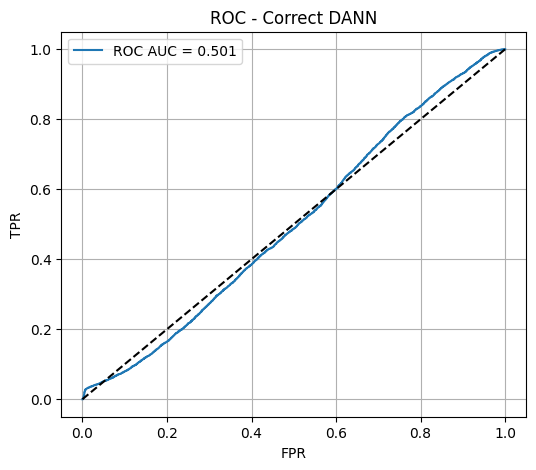

In [11]:
y_proba = model.predict_proba(X_t_test)
best_thresh, _ = find_best_threshold(y_t_test, y_proba)
y_pred = (y_proba > best_thresh).astype(int)

fpr, tpr, _ = roc_curve(y_t_test, y_proba)
roc_auc = auc(fpr, tpr)

print(f"Оптимальный threshold: {best_thresh:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"Accuracy: {accuracy_score(y_t_test, y_pred):.3f}")
print(classification_report(y_t_test, y_pred, digits=3))

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR')
plt.title('ROC - Correct DANN'); plt.legend(); plt.grid(); plt.show()